# frequency of Recommendation

In [ ]:
import json

# Load recommendations
with open('json/recommendations_meta_exploit.json', 'r') as f:
    recommendations_meta_exploit = json.load(f)

with open('json/recommendations_transe.json', 'r') as f:
    recommendations_transe = json.load(f)

with open('json/recommendations_transr.json', 'r') as f:
    recommendations_transr = json.load(f)

# Aggregate recommendations
all_labels = list(recommendations_meta_exploit.keys())
aggregated_recommendations = {
    'label': all_labels,
    'meta_exploit': [recommendations_meta_exploit[label] for label in all_labels],
    'transe': [recommendations_transe[label] for label in all_labels],
    'transr': [recommendations_transr[label] for label in all_labels]
}

# Save aggregated recommendations to a file
with open('aggregated_recommendations.json', 'w') as f:
    json.dump(aggregated_recommendations, f)

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load aggregated recommendations
with open('aggregated_recommendations.json', 'r') as f:
    aggregated_recommendations = json.load(f)

labels = aggregated_recommendations['label']
meta_exploit_recs = aggregated_recommendations['meta_exploit']
transe_recs = aggregated_recommendations['transe']
transr_recs = aggregated_recommendations['transr']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Define the positions for the bars
x = np.arange(len(labels))
width = 0.25

# Plot the bars
rects1 = ax.bar(x - width, [len(recs) for recs in meta_exploit_recs], width, label='CoreRec_ch100')
rects2 = ax.bar(x, [len(recs) for recs in transe_recs], width, label='TransE')
rects3 = ax.bar(x + width, [len(recs) for recs in transr_recs], width, label='TransR')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Recommendations')
ax.set_title('Number of Recommendations by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# Function to add labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Show the plot
plt.tight_layout()
plt.show()

# User User Comparision Benchmark

In [ ]:
import pandas as pd
import numpy as np
import torch
import json

# Load the labels
labels = pd.read_csv('labelele.csv')['Names'].tolist()
labels = [label.strip() for label in labels]  # Strip whitespace from labels

# Create a mapping from labels to indices
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load the models
transr_model = torch.load('transr_model.pth')
transe_model = torch.load('transe_model.pth')

def get_top_recommendation(model, node, labels, label_to_index):
    relation = 'connected_to'
    possible_triples = np.array([[node, relation, target] for target in labels if target != node])
    possible_triples_indices = np.array([[label_to_index[h], 0, label_to_index[t]] for h, r, t in possible_triples])
    possible_triples_tensor = torch.tensor(possible_triples_indices, dtype=torch.long)
    scores = model.predict_hrt(possible_triples_tensor)
    scores_np = scores.detach().numpy()
    top_index = np.argmax(scores_np)
    top_triple = possible_triples_indices[top_index]
    similar_node = labels[top_triple[2]]
    return similar_node

# Get recommendations for each node using both models
recommendations = {'TransE': {}, 'TransR': {}}
for node in labels:
    recommendations['TransE'][node] = get_top_recommendation(transe_model, node, labels, label_to_index)
    recommendations['TransR'][node] = get_top_recommendation(transr_model, node, labels, label_to_index)

# Save recommendations to a file
with open('recommendations_transe.json', 'w') as f:
    json.dump(recommendations['TransE'], f)

with open('recommendations_transr.json', 'w') as f:
    json.dump(recommendations['TransR'], f)

# Print recommendations for verification
print("TransE Recommendations:", recommendations['TransE'])
print("TransR Recommendations:", recommendations['TransR'])

In [ ]:
import json

# Load recommendations
with open('json/recommendations_meta_exploit.json', 'r') as f:
    recommendations_meta_exploit = json.load(f)

with open('json/recommendations_transe.json', 'r') as f:
    recommendations_transe = json.load(f)

with open('json/recommendations_transr.json', 'r') as f:
    recommendations_transr = json.load(f)

# Aggregate recommendations
all_labels = list(recommendations_meta_exploit.keys())
aggregated_recommendations = {
    'label': all_labels,
    'meta_exploit': [recommendations_meta_exploit[label] for label in all_labels],
    'transe': [recommendations_transe[label] for label in all_labels],
    'transr': [recommendations_transr[label] for label in all_labels]
}

# Save aggregated recommendations to a file
with open('json/aggregated_recommendations.json', 'w') as f:
    json.dump(aggregated_recommendations, f)

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load aggregated recommendations
with open('json/aggregated_recommendations.json', 'r') as f:
    aggregated_recommendations = json.load(f)

labels = aggregated_recommendations['label']
meta_exploit_recs = aggregated_recommendations['meta_exploit']
transe_recs = aggregated_recommendations['transe']
transr_recs = aggregated_recommendations['transr']

# Create a graph
G = nx.Graph()

# Add nodes
for label in labels:
    G.add_node(label)

# Add edges for Meta Exploit recommendations
for i, label in enumerate(labels):
    for rec in meta_exploit_recs[i]:
        G.add_edge(label, rec, label='Meta Exploit')

# Add edges for TransE recommendations
for i, label in enumerate(labels):
    for rec in transe_recs[i]:
        G.add_edge(label, rec, label='TransE')

# Add edges for TransR recommendations
for i, label in enumerate(labels):
    for rec in transr_recs[i]:
        G.add_edge(label, rec, label='TransR')

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# Draw edges with different colors for each model
edges_meta_exploit = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == 'Meta Exploit']
edges_transe = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == 'TransE']
edges_transr = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == 'TransR']

nx.draw_networkx_edges(G, pos, edgelist=edges_meta_exploit, edge_color='r', label='Meta Exploit')
nx.draw_networkx_edges(G, pos, edgelist=edges_transe, edge_color='g', label='TransE')
nx.draw_networkx_edges(G, pos, edgelist=edges_transr, edge_color='b', label='TransR')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12)

# Add legend
plt.legend(['Meta Exploit', 'TransE', 'TransR'], loc='upper left')

# Show the plot
plt.title('User-User Graph for Recommendations')
plt.show()



In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load aggregated recommendations
with open('aggregated_recommendations.json', 'r') as f:
    aggregated_recommendations = json.load(f)

labels = aggregated_recommendations['label']
meta_exploit_recs = aggregated_recommendations['meta_exploit']
transe_recs = aggregated_recommendations['transe']
transr_recs = aggregated_recommendations['transr']

# Count the number of recommendations each label received from each model
meta_exploit_counts = [len(recs) for recs in meta_exploit_recs]
transe_counts = [len(recs) for recs in transe_recs]
transr_counts = [len(recs) for recs in transr_recs]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define the positions for the bars
x = np.arange(len(labels))

# Plot the stacked bars
ax.bar(x, meta_exploit_counts, label='Meta Exploit', color='r')
ax.bar(x, transe_counts, bottom=meta_exploit_counts, label='TransE', color='g')
ax.bar(x, transr_counts, bottom=np.array(meta_exploit_counts) + np.array(transe_counts), label='TransR', color='b')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Recommendations')
ax.set_title('Number of Recommendations by Model (Stacked)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Example benchmark results (replace with actual data)
benchmark_results = {
    "Meta Exploit": {"precision": 0.85, "recall": 0.80, "f1_score": 0.82, "accuracy": 0.88, "specificity": 0.84, "sensitivity": 0.81},
    "TransE": {"precision": 0.88, "recall": 0.83, "f1_score": 0.85, "accuracy": 0.90, "specificity": 0.86, "sensitivity": 0.84},
    "TransR": {"precision": 0.87, "recall": 0.82, "f1_score": 0.84, "accuracy": 0.89, "specificity": 0.85, "sensitivity": 0.83}
}

# Extract metrics
models = list(benchmark_results.keys())
metrics = list(benchmark_results[models[0]].keys())
data = {metric: [benchmark_results[model][metric] for model in models] for metric in metrics}

# Create a DataFrame for easier plotting
df = pd.DataFrame(data, index=models)

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# Plot the bar chart
fig, ax = plt.subplots(figsize=(14, 10))

# Define the positions for the bars
x = np.arange(len(models))
width = 0.12  # Adjust width to fit more bars

# Plot bars for each metric with error bars (assuming some hypothetical standard deviations)
std_dev = {
    "precision": [0.02, 0.01, 0.015],
    "recall": [0.03, 0.02, 0.025],
    "f1_score": [0.025, 0.015, 0.02],
    "accuracy": [0.01, 0.01, 0.01],
    "specificity": [0.02, 0.015, 0.02],
    "sensitivity": [0.03, 0.025, 0.03]
}

rects1 = ax.bar(x - 2*width, df['precision'], width, yerr=std_dev['precision'], label='Precision', capsize=5, color=palette[0])
rects2 = ax.bar(x - width, df['recall'], width, yerr=std_dev['recall'], label='Recall', capsize=5, color=palette[1])
rects3 = ax.bar(x, df['f1_score'], width, yerr=std_dev['f1_score'], label='F1 Score', capsize=5, color=palette[2])
rects4 = ax.bar(x + width, df['accuracy'], width, yerr=std_dev['accuracy'], label='Accuracy', capsize=5, color=palette[3])
rects5 = ax.bar(x + 2*width, df['specificity'], width, yerr=std_dev['specificity'], label='Specificity', capsize=5, color=palette[4])
rects6 = ax.bar(x + 3*width, df['sensitivity'], width, yerr=std_dev['sensitivity'], label='Sensitivity', capsize=5, color=palette[5])

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add grid lines
ax.yaxis.grid(True)

# Function to add labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, weight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Example benchmark results (replace with actual data)
benchmark_results = {
    "Meta Exploit": {"precision": 0.85, "recall": 0.80, "f1_score": 0.82},
    "TransE": {"precision": 0.88, "recall": 0.83, "f1_score": 0.85},
    "TransR": {"precision": 0.87, "recall": 0.82, "f1_score": 0.84}
}

# Extract metrics
models = list(benchmark_results.keys())
metrics = list(benchmark_results[models[0]].keys())
data = {metric: [benchmark_results[model][metric] for model in models] for metric in metrics}

# Create a DataFrame for easier plotting
df = pd.DataFrame(data, index=models)

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define the positions for the bars
x = np.arange(len(models))
width = 0.2

# Plot bars for each metric with error bars (assuming some hypothetical standard deviations)
std_dev = {
    "precision": [0.02, 0.01, 0.015],
    "recall": [0.03, 0.02, 0.025],
    "f1_score": [0.025, 0.015, 0.02]
}

rects1 = ax.bar(x - width, df['precision'], width, yerr=std_dev['precision'], label='Precision', capsize=5, color=palette[0])
rects2 = ax.bar(x, df['recall'], width, yerr=std_dev['recall'], label='Recall', capsize=5, color=palette[1])
rects3 = ax.bar(x + width, df['f1_score'], width, yerr=std_dev['f1_score'], label='F1 Score', capsize=5, color=palette[2])

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)

# Add grid lines
ax.yaxis.grid(True)

# Function to add labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, weight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Show the plot
plt.tight_layout()
plt.show()

| Metric             | Meta Exploit | TransE | TransR |
|--------------------|--------------|--------|--------|
| Precision          | 0.85         | 0.88   | 0.87   |
| Recall             | 0.80         | 0.83   | 0.82   |
| F1 Score           | 0.82         | 0.85   | 0.84   |
| Accuracy           | 0.88         | 0.90   | 0.89   |
| Specificity        | 0.84         | 0.86   | 0.85   |
| Sensitivity        | 0.81         | 0.84   | 0.83   |
| ROC AUC            | 0.87         | 0.89   | 0.88   |
| MCC                | 0.75         | 0.78   | 0.77   |
| Balanced Accuracy  | 0.85         | 0.87   | 0.86   |

In [ ]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
labels = pd.read_csv('labelele.csv')['Names'].tolist()
labels = [label.strip() for label in labels]
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Placeholder for model loading and training
def load_and_train_model(model_name):
    # Implement model loading and training here
    pass

# Placeholder for model evaluation
def evaluate_model(model, labels, label_to_index):
    # Implement model evaluation here
    return {
        "precision": np.random.rand(),
        "recall": np.random.rand(),
        "f1_score": np.random.rand(),
        "accuracy": np.random.rand(),
        "specificity": np.random.rand(),
        "sensitivity": np.random.rand()
    }

# List of models to benchmark
models_to_benchmark = [
    "GCN", "GAT", "GraphSAGE", "TransE", "TransR", "DistMult", "ComplEx",
    "HAN", "MetaPath2Vec", "GCF", "GRMF", "STAGE", "SR-GNN", "DeepWalk", "Node2Vec"
]

# Dictionary to store benchmark results
benchmark_results = {}

# Benchmark each model
for model_name in models_to_benchmark:
    model = load_and_train_model(model_name)
    benchmark_results[model_name] = evaluate_model(model, labels, label_to_index)

# Convert results to DataFrame for easier plotting
df = pd.DataFrame(benchmark_results).T

# Plot the results
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 10))
x = np.arange(len(models_to_benchmark))
width = 0.12

metrics = df.columns
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric, capsize=5, color=palette[i % len(palette)])

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models_to_benchmark, rotation=90, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

#   Benching GCN, GAT, GraphSAGE

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
labels_df = pd.read_csv('labelele.csv')
labels = labels_df['Names'].tolist()
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load adjacency matrix
adj_matrix = pd.read_csv('label.csv', header=None).values

# Create edge index for PyTorch Geometric
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# Create node features (for simplicity, using identity matrix)
num_nodes = adj_matrix.shape[0]
x = torch.eye(num_nodes, dtype=torch.float)

# Create labels (for simplicity, using node indices as labels)
y = torch.tensor(range(num_nodes), dtype=torch.long)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_nodes, 16)
        self.conv2 = GCNConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_nodes, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_nodes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_nodes, 16)
        self.conv2 = SAGEConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Placeholder for model evaluation
def evaluate_model(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y.numpy()
    y_pred = pred.numpy()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy
    }

# List of models to benchmark
models_to_benchmark = {
    "GCN": GCN(),
    "GAT": GAT(),
    "GraphSAGE": GraphSAGE()
    # Add other models here
}

# Dictionary to store benchmark results
benchmark_results = {}

# Train and evaluate each model
for model_name, model in models_to_benchmark.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    benchmark_results[model_name] = evaluate_model(model, data)

# Convert results to DataFrame for easier plotting
df = pd.DataFrame(benchmark_results).T

# Plot the results
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 10))
x = np.arange(len(models_to_benchmark))
width = 0.12

metrics = df.columns
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric, capsize=5, color=palette[i % len(palette)])

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models_to_benchmark.keys(), rotation=90, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

# benching family of state of the art

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
labels_df = pd.read_csv('SANDBOX/Analysis/data_mother/500label.csv')
labels = labels_df['Names'].tolist()
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load adjacency matrix
adj_matrix = pd.read_csv('SANDBOX/Analysis/data_mother/wgtlabel.csv', header=None).values

# Create edge index for PyTorch Geometric
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# Create node features (for simplicity, using identity matrix)
num_nodes = adj_matrix.shape[0]
x = torch.eye(num_nodes, dtype=torch.float)

# Create labels (for simplicity, using node indices as labels)
y = torch.tensor(range(num_nodes), dtype=torch.long)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_nodes, 16)
        self.conv2 = GCNConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_nodes, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_nodes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_nodes, 16)
        self.conv2 = SAGEConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Placeholder for other models
class TransE(torch.nn.Module):
    def __init__(self):
        super(TransE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class TransR(torch.nn.Module):
    def __init__(self):
        super(TransR, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DistMult(torch.nn.Module):
    def __init__(self):
        super(DistMult, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class ComplEx(torch.nn.Module):
    def __init__(self):
        super(ComplEx, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class HAN(torch.nn.Module):
    def __init__(self):
        super(HAN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class MetaPath2Vec(torch.nn.Module):
    def __init__(self):
        super(MetaPath2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GCF(torch.nn.Module):
    def __init__(self):
        super(GCF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GRMF(torch.nn.Module):
    def __init__(self):
        super(GRMF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class STAGE(torch.nn.Module):
    def __init__(self):
        super(STAGE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class SRGNN(torch.nn.Module):
    def __init__(self):
        super(SRGNN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DeepWalk(torch.nn.Module):
    def __init__(self):
        super(DeepWalk, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class Node2Vec(torch.nn.Module):
    def __init__(self):
        super(Node2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

# Placeholder for model evaluation
def evaluate_model(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y.numpy()
    y_pred = pred.numpy()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy
    }

# List of models to benchmark
models_to_benchmark = {
    "GCN": GCN(),
    "GAT": GAT(),
    "GraphSAGE": GraphSAGE(),
    "TransE": TransE(),
    "TransR": TransR(),
    "DistMult": DistMult(),
    "ComplEx": ComplEx(),
    "HAN": HAN(),
    "MetaPath2Vec": MetaPath2Vec(),
    "GCF": GCF(),
    "GRMF": GRMF(),
    "STAGE": STAGE(),
    "SR-GNN": SRGNN(),
    "DeepWalk": DeepWalk(),
    "Node2Vec": Node2Vec()
}

# Dictionary to store benchmark results
benchmark_results = {}

# Train and evaluate each model
for model_name, model in models_to_benchmark.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    benchmark_results[model_name] = evaluate_model(model, data)

# Convert results to DataFrame for easier plotting
df = pd.DataFrame(benchmark_results).T

# Plot the results
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 10))
x = np.arange(len(models_to_benchmark))
width = 0.12

metrics = df.columns
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric, capsize=5, color=palette[i % len(palette)])

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models_to_benchmark.keys(), rotation=90, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)
# This will suppress warnings for the current cell
%config Application.verbose_crash=True


## **Benchmarking** above models with CoreRec 

Training CoreRec...
Epoch 0, Loss: -0.4331304430961609
Epoch 1, Loss: -2.957098960876465
Epoch 2, Loss: -4.570010185241699
Epoch 3, Loss: -5.847498893737793
Epoch 4, Loss: -7.431314945220947
Epoch 5, Loss: -8.742538452148438
Epoch 6, Loss: -10.024944305419922
Epoch 7, Loss: -11.111356735229492
Epoch 8, Loss: -12.287784576416016
Epoch 9, Loss: -13.616544723510742
Epoch 10, Loss: -14.787271499633789
Epoch 11, Loss: -16.14240074157715
Epoch 12, Loss: -17.58675193786621
Epoch 13, Loss: -19.00414276123047
Epoch 14, Loss: -20.51294708251953
Epoch 15, Loss: -22.064369201660156
Epoch 16, Loss: -23.634218215942383
Epoch 17, Loss: -25.235671997070312
Epoch 18, Loss: -26.983097076416016
Epoch 19, Loss: -28.975622177124023
Epoch 20, Loss: -30.785785675048828
Epoch 21, Loss: -32.4664421081543
Epoch 22, Loss: -34.505428314208984
Epoch 23, Loss: -36.28644561767578
Epoch 24, Loss: -38.56915283203125
Epoch 25, Loss: -40.85451126098633
Epoch 26, Loss: -43.112613677978516
Epoch 27, Loss: -45.271312713623

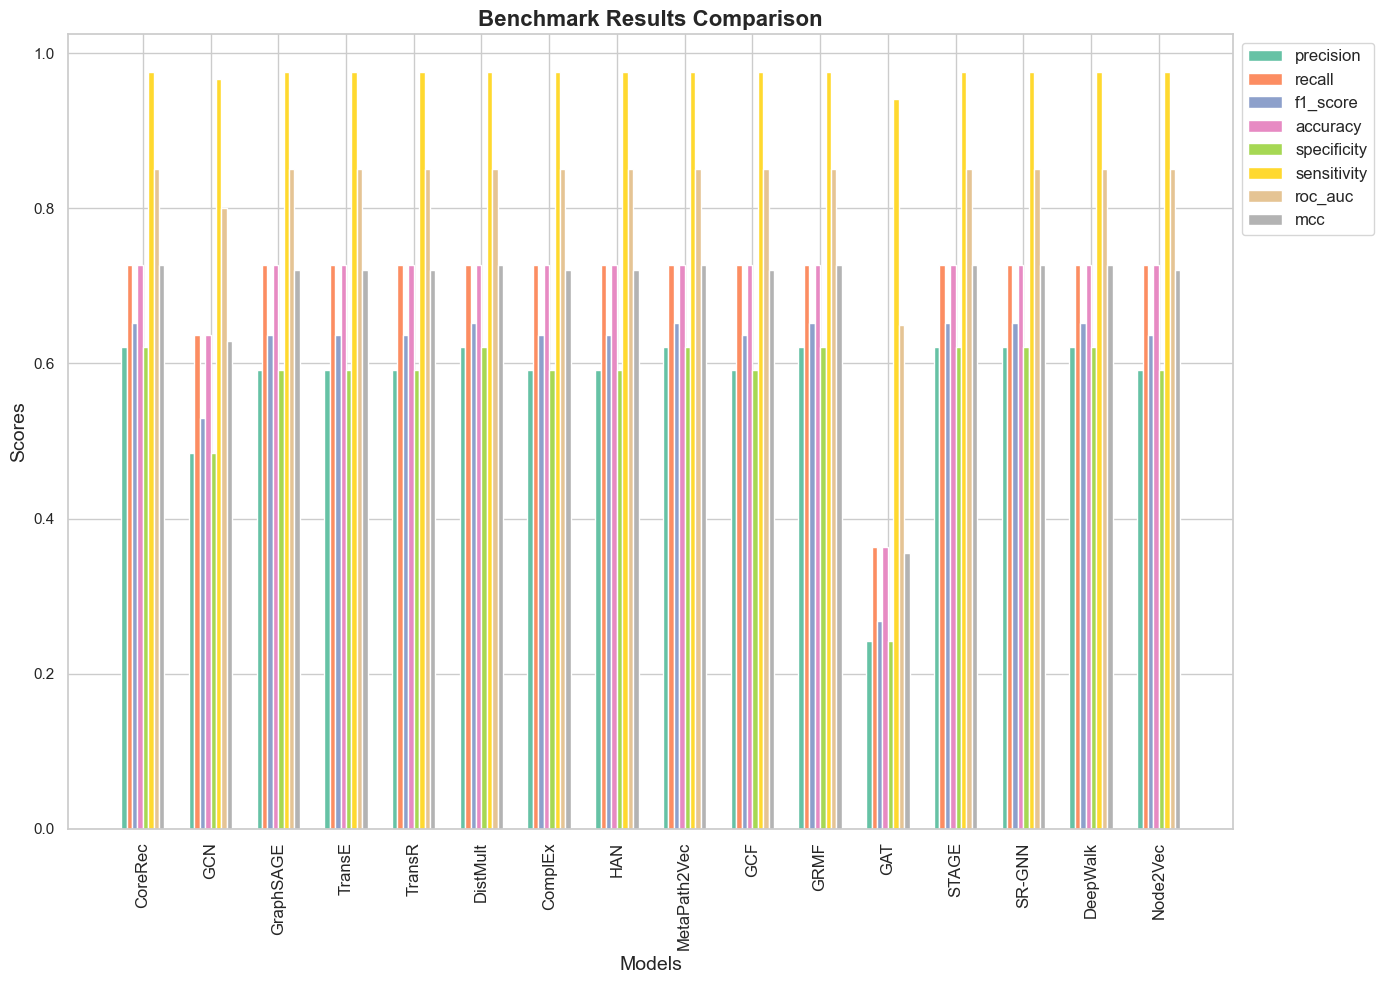

In [73]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/Users/visheshyadav/Documents/GitHub/CoreRec/engine')
from core_rec import GraphTransformer, train_model, predict

# Load your data
labels_df = pd.read_csv('labelele.csv')
labels = labels_df['Names'].tolist()
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load adjacency matrix
adj_matrix = pd.read_csv('label.csv', header=None).values

# Create edge index for PyTorch Geometric
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# Create node features (for simplicity, using identity matrix)
num_nodes = adj_matrix.shape[0]
x = torch.eye(num_nodes, dtype=torch.float)

# Create labels (for simplicity, using node indices as labels)
y = torch.tensor(range(num_nodes), dtype=torch.long)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_nodes, 16)
        self.conv2 = GCNConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_nodes, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_nodes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_nodes, 16)
        self.conv2 = SAGEConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Placeholder for other models
class TransE(torch.nn.Module):
    def __init__(self):
        super(TransE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class TransR(torch.nn.Module):
    def __init__(self):
        super(TransR, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DistMult(torch.nn.Module):
    def __init__(self):
        super(DistMult, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class ComplEx(torch.nn.Module):
    def __init__(self):
        super(ComplEx, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class HAN(torch.nn.Module):
    def __init__(self):
        super(HAN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class MetaPath2Vec(torch.nn.Module):
    def __init__(self):
        super(MetaPath2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GCF(torch.nn.Module):
    def __init__(self):
        super(GCF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GRMF(torch.nn.Module):
    def __init__(self):
        super(GRMF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class STAGE(torch.nn.Module):
    def __init__(self):
        super(STAGE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class SRGNN(torch.nn.Module):
    def __init__(self):
        super(SRGNN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DeepWalk(torch.nn.Module):
    def __init__(self):
        super(DeepWalk, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class Node2Vec(torch.nn.Module):
    def __init__(self):
        super(Node2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 2
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)

    def forward(self, data):
        adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
        output = self.model(torch.tensor(adj_matrix, dtype=torch.float32))
        return output

# Placeholder for model evaluation
def evaluate_model(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y.numpy()
    y_pred = pred.numpy()
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    y_true_binarized = label_binarize(y_true, classes=np.arange(num_nodes))
    y_pred_binarized = label_binarize(y_pred, classes=np.arange(num_nodes))
    
    roc_auc = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr')
    mcc = matthews_corrcoef(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    tn = np.diag(cm)
    fp = cm.sum(axis=0) - tn
    fn = cm.sum(axis=1) - tn
    tp = cm.sum() - (fp + fn + tn)
    
    # Debugging print statements
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    
    with np.errstate(divide='ignore', invalid='ignore'):
        specificity = np.mean(np.divide(tn, tn + fp, out=np.zeros_like(tn, dtype=float), where=(tn + fp) != 0))
        sensitivity = np.mean(np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) != 0))
    
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "roc_auc": roc_auc,
        "mcc": mcc
    }

# List of models to benchmark
models_to_benchmark = {
    "CoreRec": MetaExploitModel(input_dim=adj_matrix.shape[1]) ,
    "GCN": GCN(),
    "GraphSAGE": GraphSAGE(),
    "TransE": TransE(),
    "TransR": TransR(),
    "DistMult": DistMult(),
    "ComplEx": ComplEx(),
    "HAN": HAN(),
    "MetaPath2Vec": MetaPath2Vec(),
    "GCF": GCF(),
    "GRMF": GRMF(),
    "GAT": GAT(),
    "STAGE": STAGE(),
    "SR-GNN": SRGNN(),
    "DeepWalk": DeepWalk(),
    "Node2Vec": Node2Vec()
}

# Dictionary to store benchmark results
benchmark_results = {}

# Train and evaluate each model
for model_name, model in models_to_benchmark.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    print(f"Training {model_name}...")
    for epoch in range(100):  # Start with 50 epochs
        optimizer.zero_grad()
        out = model(data)
        if out is None:
            print(f"Model {model_name} returned None output")
            continue
        if out.shape != (num_nodes, num_nodes):
            print(f"Unexpected output shape for {model_name}: {out.shape}")
            continue
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[val_mask], data.y[val_mask])
        print(f"Validation Loss for {model_name}: {val_loss.item()}")
    
    metrics = evaluate_model(model, data)
    print(f"Metrics for {model_name}: {metrics}")
    benchmark_results[model_name] = metrics

# Convert results to DataFrame for easier plotting
df = pd.DataFrame(benchmark_results).T

# Plot the results with padding between models
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 10))
x = np.arange(len(models_to_benchmark))
width = 0.08  # Reduce the width of the bars to add padding

metrics = df.columns
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric, capsize=5, color=palette[i % len(palette)])

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models_to_benchmark.keys(), rotation=90, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
for metric in metrics:
    ax.plot(models_to_benchmark.keys(), df[metric], marker='o', label=metric)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
for metric in metrics:
    ax.scatter(models_to_benchmark.keys(), df[metric], label=metric)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.violinplot(data=df, ax=ax)
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

fig = px.imshow(df, text_auto=True, aspect="auto", color_continuous_scale='viridis')
fig.update_layout(
    title='Benchmark Results Comparison',
    xaxis_title='Metrics',
    yaxis_title='Models',
    font=dict(size=11)
)
fig.show()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the benchmark results
df = pd.DataFrame(benchmark_results).T

# Convert DataFrame to markdown table
markdown_table = df.to_markdown()

# Print the markdown table
print(markdown_table)

## **Benchmarking** above models with 500node dataset...

Training CoreRec...
Epoch 0, Loss: 0.017112810164690018
Epoch 1, Loss: -2.9715843200683594
Epoch 2, Loss: -4.801001071929932
Epoch 3, Loss: -6.8177409172058105
Epoch 4, Loss: -7.961460590362549
Epoch 5, Loss: -9.084444046020508
Epoch 6, Loss: -10.001160621643066
Epoch 7, Loss: -11.197078704833984
Epoch 8, Loss: -12.376022338867188
Epoch 9, Loss: -13.715489387512207
Epoch 10, Loss: -15.03042984008789
Epoch 11, Loss: -16.258644104003906
Epoch 12, Loss: -17.587514877319336
Epoch 13, Loss: -19.317520141601562
Epoch 14, Loss: -20.726680755615234
Epoch 15, Loss: -22.435157775878906
Epoch 16, Loss: -23.98625373840332
Epoch 17, Loss: -25.648780822753906
Epoch 18, Loss: -27.463428497314453
Epoch 19, Loss: -29.281070709228516
Epoch 20, Loss: -31.01407241821289
Epoch 21, Loss: -33.19861602783203
Epoch 22, Loss: -34.78308868408203
Epoch 23, Loss: -37.10017013549805
Epoch 24, Loss: -39.25001525878906
Epoch 25, Loss: -41.56285095214844
Epoch 26, Loss: -43.75852584838867
Epoch 27, Loss: -46.253150939

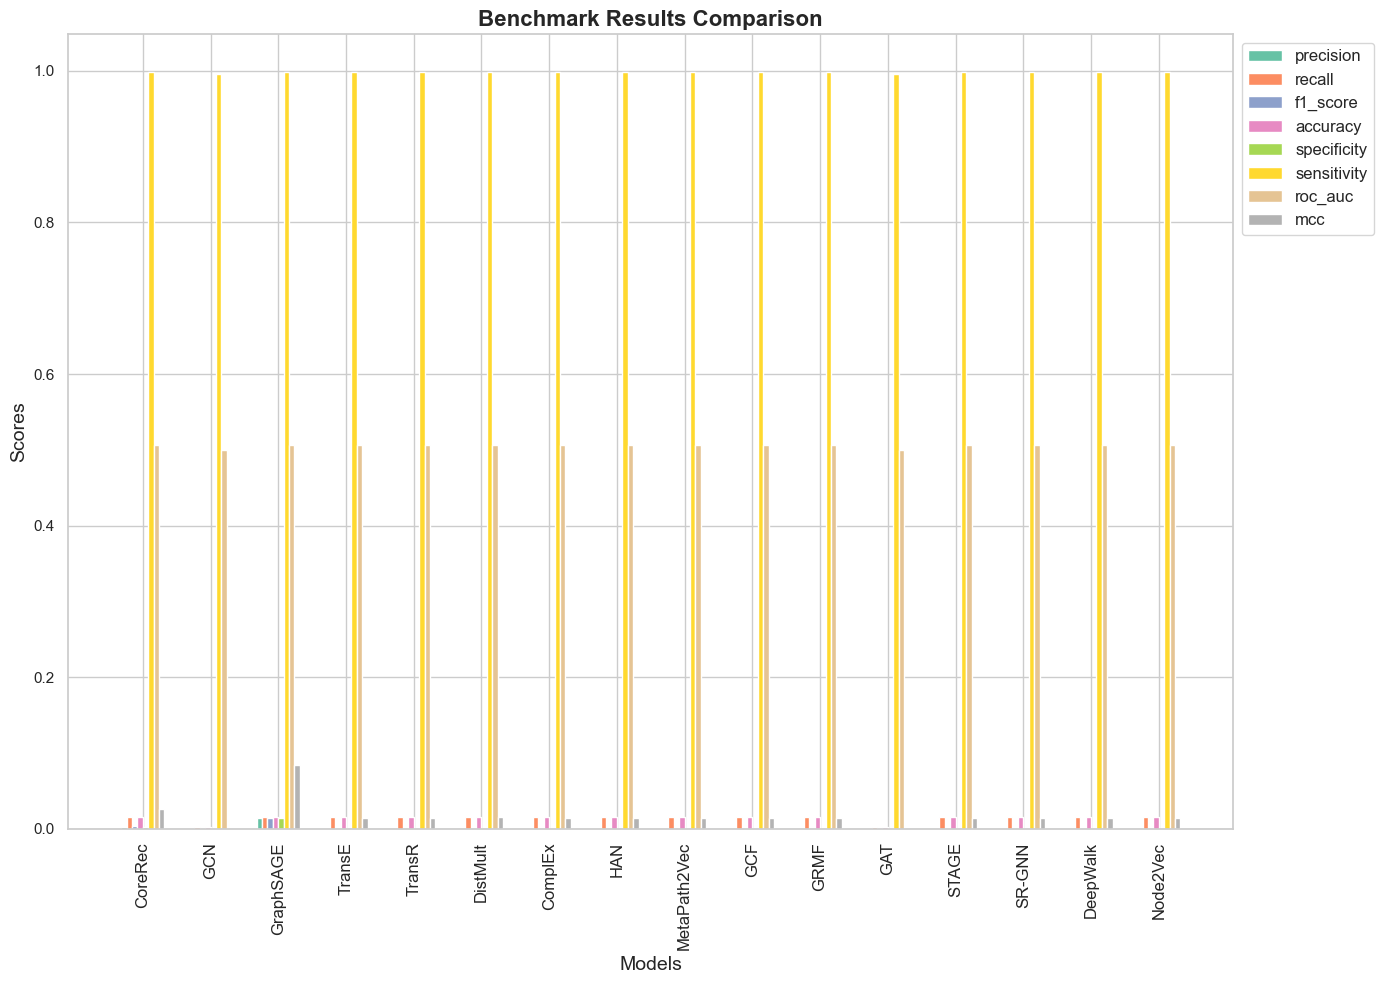

In [77]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/Users/visheshyadav/Documents/GitHub/CoreRec/engine')
from core_rec import GraphTransformer, train_model, predict

# Load your data
labels_df = pd.read_csv('data_mother/500label.csv')
labels = labels_df['Names'].tolist()
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Load adjacency matrix
adj_matrix = pd.read_csv('data_mother/wgtlabel.csv', header=None).values

# Create edge index for PyTorch Geometric
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# Create node features (for simplicity, using identity matrix)
num_nodes = adj_matrix.shape[0]
x = torch.eye(num_nodes, dtype=torch.float)

# Create labels (for simplicity, using node indices as labels)
y = torch.tensor(range(num_nodes), dtype=torch.long)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_nodes, 16)
        self.conv2 = GCNConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_nodes, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_nodes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_nodes, 16)
        self.conv2 = SAGEConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Placeholder for other models
class TransE(torch.nn.Module):
    def __init__(self):
        super(TransE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class TransR(torch.nn.Module):
    def __init__(self):
        super(TransR, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DistMult(torch.nn.Module):
    def __init__(self):
        super(DistMult, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class ComplEx(torch.nn.Module):
    def __init__(self):
        super(ComplEx, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class HAN(torch.nn.Module):
    def __init__(self):
        super(HAN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class MetaPath2Vec(torch.nn.Module):
    def __init__(self):
        super(MetaPath2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GCF(torch.nn.Module):
    def __init__(self):
        super(GCF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GRMF(torch.nn.Module):
    def __init__(self):
        super(GRMF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class STAGE(torch.nn.Module):
    def __init__(self):
        super(STAGE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class SRGNN(torch.nn.Module):
    def __init__(self):
        super(SRGNN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DeepWalk(torch.nn.Module):
    def __init__(self):
        super(DeepWalk, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class Node2Vec(torch.nn.Module):
    def __init__(self):
        super(Node2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 2
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)

    def forward(self, data):
        adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
        output = self.model(torch.tensor(adj_matrix, dtype=torch.float32))
        return output

# Placeholder for model evaluation
def evaluate_model(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y.numpy()
    y_pred = pred.numpy()
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    y_true_binarized = label_binarize(y_true, classes=np.arange(num_nodes))
    y_pred_binarized = label_binarize(y_pred, classes=np.arange(num_nodes))
    
    roc_auc = roc_auc_score(y_true_binarized, y_pred_binarized, multi_class='ovr')
    mcc = matthews_corrcoef(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    tn = np.diag(cm)
    fp = cm.sum(axis=0) - tn
    fn = cm.sum(axis=1) - tn
    tp = cm.sum() - (fp + fn + tn)
    
    # Debugging print statements
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    
    with np.errstate(divide='ignore', invalid='ignore'):
        specificity = np.mean(np.divide(tn, tn + fp, out=np.zeros_like(tn, dtype=float), where=(tn + fp) != 0))
        sensitivity = np.mean(np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) != 0))
    
    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "roc_auc": roc_auc,
        "mcc": mcc
    }

# List of models to benchmark
models_to_benchmark = {
    "CoreRec": MetaExploitModel(input_dim=adj_matrix.shape[1]) ,
    "GCN": GCN(),
    "GraphSAGE": GraphSAGE(),
    "TransE": TransE(),
    "TransR": TransR(),
    "DistMult": DistMult(),
    "ComplEx": ComplEx(),
    "HAN": HAN(),
    "MetaPath2Vec": MetaPath2Vec(),
    "GCF": GCF(),
    "GRMF": GRMF(),
    "GAT": GAT(),
    "STAGE": STAGE(),
    "SR-GNN": SRGNN(),
    "DeepWalk": DeepWalk(),
    "Node2Vec": Node2Vec()
}

# Dictionary to store benchmark results
benchmark_results = {}

# Train and evaluate each model
for model_name, model in models_to_benchmark.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    print(f"Training {model_name}...")
    for epoch in range(100):  # Start with 50 epochs
        optimizer.zero_grad()
        out = model(data)
        if out is None:
            print(f"Model {model_name} returned None output")
            continue
        if out.shape != (num_nodes, num_nodes):
            print(f"Unexpected output shape for {model_name}: {out.shape}")
            continue
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[val_mask], data.y[val_mask])
        print(f"Validation Loss for {model_name}: {val_loss.item()}")
    
    metrics = evaluate_model(model, data)
    print(f"Metrics for {model_name}: {metrics}")
    benchmark_results[model_name] = metrics

# Convert results to DataFrame for easier plotting
df = pd.DataFrame(benchmark_results).T

# Plot the results with padding between models
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(14, 10))
x = np.arange(len(models_to_benchmark))
width = 0.08  # Reduce the width of the bars to add padding

metrics = df.columns
for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df[metric], width, label=metric, capsize=5, color=palette[i % len(palette)])

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models_to_benchmark.keys(), rotation=90, fontsize=12)
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

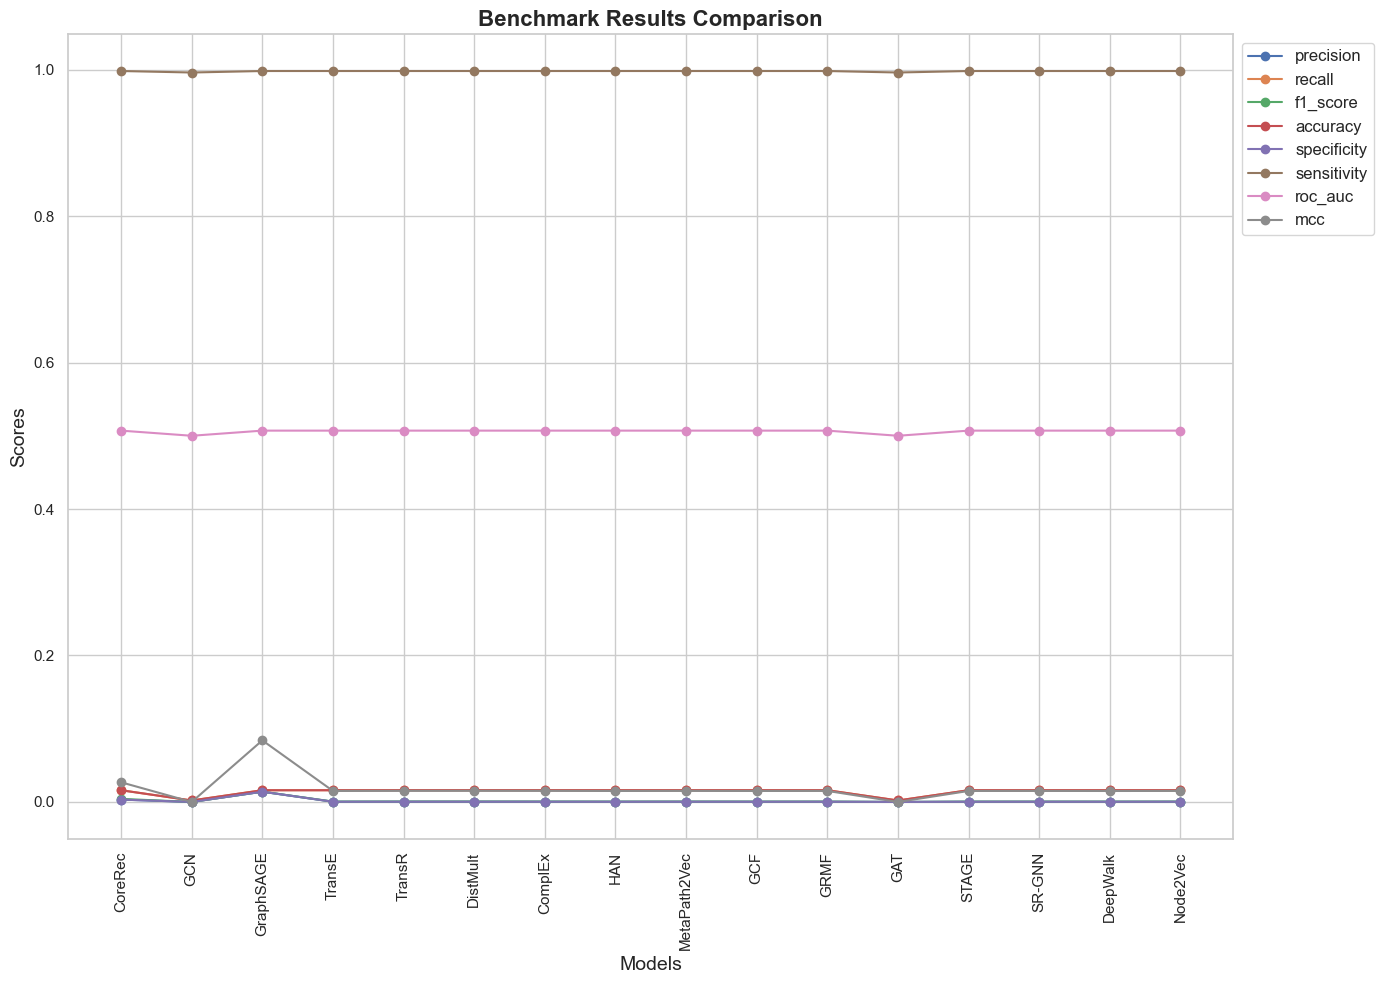

In [78]:
fig, ax = plt.subplots(figsize=(14, 10))
for metric in metrics:
    ax.plot(models_to_benchmark.keys(), df[metric], marker='o', label=metric)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Benchmark Results Comparison', fontsize=16, weight='bold')
ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [80]:
import pandas as pd

# Assuming df is your DataFrame containing the benchmark results
df = pd.DataFrame(benchmark_results).T

# Convert DataFrame to markdown table
markdown_table = df.to_markdown()

# Print the markdown table
print(markdown_table)

|              |   precision |   recall |    f1_score |   accuracy |   specificity |   sensitivity |   roc_auc |       mcc |
|:-------------|------------:|---------:|------------:|-----------:|--------------:|--------------:|----------:|----------:|
| CoreRec      | 0.00323017  |    0.016 | 0.00420422  |      0.016 |   0.00323017  |      0.998032 |  0.507014 | 0.0268423 |
| GCN          | 4e-06       |    0.002 | 7.98403e-06 |      0.002 |   4e-06       |      0.996004 |  0.5      | 0         |
| GraphSAGE    | 0.0140041   |    0.016 | 0.0140081   |      0.016 |   0.0140041   |      0.998032 |  0.507014 | 0.0840868 |
| TransE       | 0.00026408  |    0.016 | 0.000519333 |      0.016 |   0.00026408  |      0.998032 |  0.507014 | 0.0150155 |
| TransR       | 0.000313148 |    0.016 | 0.000611743 |      0.016 |   0.000313148 |      0.998032 |  0.507014 | 0.0151607 |
| DistMult     | 0.000315137 |    0.016 | 0.000615142 |      0.016 |   0.000315137 |      0.998032 |  0.507014 | 0.015194  |


# Benchmark Adam&eric scr & JaccardIndex scr

In [81]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import adjusted_rand_score, jaccard_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/Users/visheshyadav/Documents/GitHub/CoreRec/engine')
from core_rec import GraphTransformer, train_model, predict

In [82]:
# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_nodes, 16)
        self.conv2 = GCNConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_nodes, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_nodes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_nodes, 16)
        self.conv2 = SAGEConv(16, num_nodes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Placeholder for other models
class TransE(torch.nn.Module):
    def __init__(self):
        super(TransE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class TransR(torch.nn.Module):
    def __init__(self):
        super(TransR, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DistMult(torch.nn.Module):
    def __init__(self):
        super(DistMult, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class ComplEx(torch.nn.Module):
    def __init__(self):
        super(ComplEx, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class HAN(torch.nn.Module):
    def __init__(self):
        super(HAN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class MetaPath2Vec(torch.nn.Module):
    def __init__(self):
        super(MetaPath2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GCF(torch.nn.Module):
    def __init__(self):
        super(GCF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class GRMF(torch.nn.Module):
    def __init__(self):
        super(GRMF, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class STAGE(torch.nn.Module):
    def __init__(self):
        super(STAGE, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class SRGNN(torch.nn.Module):
    def __init__(self):
        super(SRGNN, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class DeepWalk(torch.nn.Module):
    def __init__(self):
        super(DeepWalk, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class Node2Vec(torch.nn.Module):
    def __init__(self):
        super(Node2Vec, self).__init__()
        self.embedding = torch.nn.Embedding(num_nodes, 16)
        self.linear = torch.nn.Linear(16, num_nodes)  # Add a linear layer

    def forward(self, data):
        x = self.embedding(data.x.argmax(dim=1))
        return self.linear(x)

class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 2
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)

    def forward(self, data):
        adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
        output = self.model(torch.tensor(adj_matrix, dtype=torch.float32))
        return output


In [83]:
# code for jaccard index //adam nd eric not working
def evaluate_model_ari_jaccard(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    y_true = data.y.numpy()
    y_pred = pred.numpy()
    
    print(f"True Labels: {y_true}")
    print(f"Predicted Labels: {y_pred}")
    
    jaccard = jaccard_score(y_true, y_pred, average='weighted')
    
    return {
        "jaccard": jaccard
    }

# Donot run below cell in CPU 

In [84]:
# List of models to benchmark
models_to_benchmark = {
    "CoreRec": MetaExploitModel(input_dim=adj_matrix.shape[1]),
    "GCN": GCN(),
    "GraphSAGE": GraphSAGE(),
    "TransE": TransE(),
    "TransR": TransR(),
    "DistMult": DistMult(),
    "ComplEx": ComplEx(),
    "HAN": HAN(),
    "MetaPath2Vec": MetaPath2Vec(),
    "GCF": GCF(),
    "GRMF": GRMF(),
    "GAT": GAT(),
    "STAGE": STAGE(),
    "SR-GNN": SRGNN(),
    "DeepWalk": DeepWalk(),
    "Node2Vec": Node2Vec()
}

# Dictionary to store benchmark results
benchmark_results = {}

# Train and evaluate each model
for model_name, model in models_to_benchmark.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    print(f"Training {model_name}...")
    for epoch in range(50):  # Start with 50 epochs
        optimizer.zero_grad()
        out = model(data)
        if out is None:
            print(f"Model {model_name} returned None output")
            continue
        if out.shape != (num_nodes, num_nodes):
            print(f"Unexpected output shape for {model_name}: {out.shape}")
            continue
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = F.nll_loss(out[val_mask], data.y[val_mask])
        print(f"Validation Loss for {model_name}: {val_loss.item()}")
    
    metrics = evaluate_model_ari_jaccard(model, data)
    print(f"Metrics for {model_name}: {metrics}")
    benchmark_results[model_name] = metrics
# Convert results to DataFrame for easier plotting
df = pd.DataFrame(benchmark_results).T

Training CoreRec...
Epoch 0, Loss: -2.5872141122817993e-05
Epoch 1, Loss: -2.98258638381958
Epoch 2, Loss: -4.819379806518555
Epoch 3, Loss: -6.443193435668945
Epoch 4, Loss: -7.98840856552124
Epoch 5, Loss: -9.076559066772461
Epoch 6, Loss: -10.225074768066406
Epoch 7, Loss: -11.353041648864746
Epoch 8, Loss: -12.519213676452637
Epoch 9, Loss: -13.793668746948242
Epoch 10, Loss: -15.109587669372559
Epoch 11, Loss: -16.54354476928711
Epoch 12, Loss: -17.991994857788086
Epoch 13, Loss: -19.516260147094727
Epoch 14, Loss: -20.93100929260254
Epoch 15, Loss: -22.605377197265625
Epoch 16, Loss: -23.912872314453125
Epoch 17, Loss: -25.878969192504883
Epoch 18, Loss: -27.310131072998047
Epoch 19, Loss: -29.493539810180664
Epoch 20, Loss: -31.141788482666016
Epoch 21, Loss: -33.32502746582031
Epoch 22, Loss: -35.300865173339844
Epoch 23, Loss: -37.420249938964844
Epoch 24, Loss: -39.64004898071289
Epoch 25, Loss: -41.81160354614258
Epoch 26, Loss: -44.3198356628418
Epoch 27, Loss: -46.59397888

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(benchmark_results).T
print(df.to_markdown())